# **Step 1 : Load [Dataset A] and split it according to the designed ratio.**

In [ ]:
!pip install transformers datasets peft sacrebleu torch bitsandbytes accelerate groq

In [6]:
# Import necessary libraries for dataset handling, model training, and evaluation
from datasets import load_dataset
import random
import torch
import os
import json
import time
import requests
from transformers import T5ForConditionalGeneration, T5Tokenizer, BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
import sacrebleu
from groq import Groq,RateLimitError, APIError, AuthenticationError, APIConnectionError


**Load the `opus100` dataset (German-to-French, test split) as the benchmark`Dataset A`, following the guideline to select 1,000 pairs randomly if larger,split into 80% training (Dataset A: Train) and 20% testing (Dataset A: Test) and save as JSON files for later use.**

In [ ]:
# Load opus100 dataset for German-to-French, using the "test" split
dataset = load_dataset("opus100", "de-fr", split="test")

# Sample 1,000 pairs if available, otherwise use all
dataset_a = dataset.shuffle(seed=42).select(range(min(1000, len(dataset))))

# Convert to list of dictionaries
pairs = [{"de": ex["translation"]["de"], "fr": ex["translation"]["fr"]} for ex in dataset_a]

# Split according to the designed 80:20 ratio
total_pairs = len(pairs)
train_data_a = pairs[:int(total_pairs * 0.8)]  # Dataset A: Train (80%)
test_data_a = pairs[int(total_pairs * 0.8):]   # Dataset A: Test (20%)

# Save them as json formate
os.makedirs("datasets", exist_ok=True)
with open("datasets/DatasetA_Train.json", "w") as f:
    json.dump(train_data_a, f, indent=4)

with open("datasets/DatasetA_Test.json", "w") as f:
    json.dump(test_data_a, f, indent=4)

# Verify
print(f"Dataset A size: {len(pairs)}")
print("Sample pair:", pairs[0])

Dataset A size: 1000
Sample pair: {'de': 'Nach 2 Zentimeter, drehen Sie leicht nach rechts." Francette!', 'fr': 'Dans 2 centimetres, tournez legerement a droite.'}


# **Step 2 : Load your chosen pre-trained model [Model A].**

**Load `google/flan-t5-xl` as `Model A`, a pre-trained general-purpose LLM with ~3B parameters , using 4-bit quantization to reduce memory usage for Colab compatibility, along with its tokenizer, and set the device to GPU (if available) or CPU.**

In [ ]:
# Load model with 4-bit quantization
#from transformers import T5ForConditionalGeneration, T5Tokenizer, BitsAndBytesConfig
#import torch
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
# Load google/flan-t5-xl as Model A
model_a = T5ForConditionalGeneration.from_pretrained(
    "google/flan-t5-xl",
    quantization_config=quant_config,
    device_map="auto"
)
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl") # Load the corresponding tokenizer for flan-t5-xl to process input text
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model A loaded with 4-bit quantization on:", device)


config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Model A loaded with 4-bit quantization on: cuda


# **Step 3 : Evaluate [Model A] on the test dataset [Dataset A: Test] using the chosen metric.**

**Define an evaluation function using BLEU as the metric and evaluate `Model A` on `Dataset A: Test` to establish a baseline performance for German-to-French translation.**

In [ ]:
#import sacrebleu

# Define a function to evaluate the model using BLEU score
def evaluate(model, test_data, tokenizer, device):
    model.eval()  # Set to evaluation mode
    preds = []
    refs = []

    for pair in test_data:
        input_text = f"translate German to French: {pair['de']}"
        # Tokenize and move to GPU
        inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True).to(device)

        # Generate translation with GPU
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=256, num_beams=2)  # Beam search for better quality
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        preds.append(pred)
        refs.append(pair["fr"])

    # Compute BLEU score
    bleu_score = sacrebleu.corpus_bleu(preds, [refs]).score
    return bleu_score

# Run evaluation on Model A using Dataset A: Test to establish baseline performance
bleu_a = evaluate(model_a, test_data_a, tokenizer, device)
print(f"Model A BLEU Score: {bleu_a}")

Model A BLEU Score: 15.327606115293634


# **Step 4_5 : Fine-tune [Model A] on the training dataset [Dataset A: Train] to create [Model B]. & Evaluate [Model B] on the test dataset [Dataset A: Test] using the chosen metric.**

**Apply LoRA (Low-Rank Adaptation) to `Model A` to create `Model B`, as chosen in the Design Phase for efficient fine-tuning on Colab due to memory constraints. Prepare `Dataset A: Train` for training, set up the training configuration, fine-tune the model, and save `Model B` for later evaluation.**

**Evaluate `Model B` on `Dataset A: Test` using the BLEU metric to assess its performance after fine-tuning on real data, comparing it to the baseline (`Model A`).**

In [ ]:
#from peft import LoraConfig, get_peft_model
#from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

#Apply LoRA for efficient fine-tuning choice for Colab compatibility
model_b = get_peft_model(model_a, LoraConfig(r=8, lora_alpha=32, target_modules=["q", "v"]))

# Prepare training data with reduced max_length
train_inputs = [f"translate German to French: {x['de']}" for x in train_data_a]
train_labels = [x["fr"] for x in train_data_a]
train_encodings = tokenizer(train_inputs, text_target=train_labels,
                           return_tensors="pt", padding=True, truncation=True, max_length=128)

# Custom Dataset class
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].clone()  # Labels are the target translations
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = TranslationDataset(train_encodings)

# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_b, padding=True, max_length=128)

# Define training arguments with optimizations
training_args = TrainingArguments(
    output_dir="./model_b",
    per_device_train_batch_size=1,  # Reduced to fit memory
    gradient_accumulation_steps=4,  # Effective batch size of 4
    num_train_epochs=2,  # Limited epochs to manage training time on Colab
    save_steps=50,  # Save checkpoint every 50 steps
    logging_steps=10,
    evaluation_strategy="no",  # No validation set for simplicity
    save_total_limit=1,  # Keep only the latest checkpoint to save disk space
    load_best_model_at_end=False,
)

# Initialize Trainer for fine-tuning
trainer_B = Trainer(
    model=model_b,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

# Fine-tune Model A on Dataset A: Train to create Model B
trainer_B.train()

# Use the evaluate function with BLEU metric to compute performance
bleu_b = evaluate(model_b, test_data_a, tokenizer, device)
print(f"Model B BLEU: {bleu_b}")

trainer_B.save_model("ModelB")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss
10,32.250000
20,30.418200
30,29.532500
40,27.382200
50,24.190400
60,20.889100
70,17.007200
80,14.224600
90,10.928300
100,7.278500


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

Model B BLEU: 2.714674002080706


# **Step 6 : Use the designed prompt to generate a new synthesized dataset [Dataset B], twice the size of the training set [Dataset A: Train], using the selected larger model.**

**Generate 1,600 synthetic German-to-French translation pairs using the Groq API with the `mixtral-8x7b-32768` model with 32B+ parameters to create `Dataset B`, expanding the training data, and save as a JSON file.**

In [ ]:
# Generate Dataset B using Groq API

# Set up Groq API client with the API key
client = Groq(api_key="your API Key")

# Function to generate synthetic data using Groq API
def generate_with_groq(prompts, retries=5, initial_wait=5):
    """
    Sends batch requests to Groq API and handles rate limits (429 errors).
    """
    messages = [
        {"role": "system", "content": "You are a JSON generator. Output ONLY a JSON object with keys and string values enclosed in DOUBLE QUOTES, with no additional text, explanations, or formatting outside the JSON. For example: {\"de\": \"Die Kinder spielen im Park.\", \"fr\": \"Les enfants jouent dans le parc.\"}"},
        {"role": "user", "content": prompts[0]}  # Same prompt for all in batch
    ]
    attempt = 0
    wait_time = initial_wait
    while attempt < retries:
        try:
            responses = []
            for _ in range(len(prompts)):
                response = client.chat.completions.create(
                    model="mixtral-8x7b-32768",
                    messages=messages,
                    max_tokens=150,
                    temperature=0.8,
                    top_p=0.9
                )
                content = response.choices[0].message.content
                responses.append(content)
                #print(f"Debug: Raw response for prompt: {content}")
            return responses
        except RateLimitError as e:
            print(f"Rate limit hit (429). Retrying in {wait_time} seconds... Error: {e}")
            time.sleep(wait_time)
            wait_time *= 2
            attempt += 1
        except AuthenticationError as e:
            print(f"Authentication Error (401): Invalid API key. Error: {e}")
            break
        except APIError as e:
            print(f"API Error (e.g., 400, 404, 500): {e}. Retrying in {wait_time} sec...")
            time.sleep(wait_time)
            wait_time *= 2
            attempt += 1
        except APIConnectionError as e:
            print(f"Network Error: {e}. Retrying in {wait_time} sec...")
            time.sleep(wait_time)
            wait_time *= 2
            attempt += 1
        except Exception as e:
            print(f"Unexpected Error: {type(e).__name__}: {e}. Retrying in {wait_time} sec...")
            time.sleep(wait_time)
            wait_time *= 2
            attempt += 1
    print("Max retries reached. Skipping batch.")
    return ["[Generation Failed]"] * len(prompts)


# Define the prompt for synthetic data generation
prompt = """
Generate a synthetic German sentence and its French translation. The German sentence must be 5-15 words, grammatically correct, and contextually meaningful. Output ONLY a JSON object in the format {"de": "<German>", "fr": "<French>"}, using DOUBLE QUOTES for all keys and string values, with no additional text, explanations, or formatting outside the JSON. For example: {"de": "Die Kinder spielen im Park.", "fr": "Les enfants jouent dans le parc."}
"""

# Generate 1,600 synthetic pairs in batches to manage API rate limits
dataset_b = []
batch_size = 10
for i in range(0, 1600, batch_size):
    batch_prompts = [prompt] * min(batch_size, 1600 - i) # Create a batch of prompts
    generations = generate_with_groq(batch_prompts)
    batch_pairs = []
    for gen in generations:
        try:
            if gen == "[Generation Failed]":
                pair = {"de": "Default German sentence", "fr": "Default French translation"}
            else:
                pair = json.loads(gen) Convert JSON string to dictionary
            batch_pairs.append(pair)
        except (json.JSONDecodeError, KeyError, IndexError) as e:
            print(f"JSON Parsing Error: {e}. Using default pair. Raw output: {gen}")
            batch_pairs.append({"de": "Dies ist der deutsche Standardsatz ", "fr": "c'est la phrase standard allemande"})
    dataset_b.extend(batch_pairs)
    print(f" Generated {i + len(batch_pairs)}/{1600} pairs...")

# Ensure exactly 1,600 pairs in Dataset B
dataset_b = dataset_b[:1600]
with open("datasets/DatasetB.json", "w", encoding="utf-8") as f:
    json.dump(dataset_b, f, ensure_ascii=False, indent=4)
print("Dataset B saved to datasets/DatasetB.json")




# Test the prompt individually first
# test_prompt = """
# Generate a synthetic German sentence and its French translation. The German sentence must be 5-15 words, grammatically correct, and contextually meaningful. Output ONLY a JSON object in the format {"de": "<German>", "fr": "<French>"}, using DOUBLE QUOTES for all keys and string values, with no additional text, explanations, or formatting outside the JSON. For example: {"de": "Die Kinder spielen im Park.", "fr": "Les enfants jouent dans le parc."}
# """
# try:
#     test_response = client.chat.completions.create(
#         model="llama3-70b-8192",
#         messages=[
#             {"role": "system", "content": "You are a JSON generator. Output ONLY a JSON object with keys and string values enclosed in DOUBLE QUOTES, with no additional text, explanations, or formatting outside the JSON. For example: {\"de\": \"Die Kinder spielen im Park.\", \"fr\": \"Les enfants jouent dans le parc.\"}"},
#             {"role": "user", "content": test_prompt}
#         ],
#         max_tokens=150,
#         temperature=0.7,
#         top_p=0.9
#     )
#     test_content = test_response.choices[0].message.content
#     print(f"Test Response: {test_content}")
#     try:
#         pair = json.loads(test_content)
#         print(f"Parsed Test Pair: {pair}")
#     except json.JSONDecodeError as e:
#         print(f"Test JSON Parsing Error: {e}")
# except Exception as e:
#     print(f"Test API Error: {type(e).__name__}: {e}")

 Generated 10/1600 pairs...
 Generated 20/1600 pairs...
 Generated 30/1600 pairs...
 Generated 40/1600 pairs...
 Generated 50/1600 pairs...
 Generated 60/1600 pairs...
 Generated 70/1600 pairs...
 Generated 80/1600 pairs...
 Generated 90/1600 pairs...
 Generated 100/1600 pairs...
 Generated 110/1600 pairs...
 Generated 120/1600 pairs...
 Generated 130/1600 pairs...
 Generated 140/1600 pairs...
 Generated 150/1600 pairs...
 Generated 160/1600 pairs...
 Generated 170/1600 pairs...
 Generated 180/1600 pairs...
 Generated 190/1600 pairs...
 Generated 200/1600 pairs...
 Generated 210/1600 pairs...
 Generated 220/1600 pairs...
 Generated 230/1600 pairs...
 Generated 240/1600 pairs...
 Generated 250/1600 pairs...
 Generated 260/1600 pairs...
 Generated 270/1600 pairs...
 Generated 280/1600 pairs...
 Generated 290/1600 pairs...
 Generated 300/1600 pairs...
 Generated 310/1600 pairs...
 Generated 320/1600 pairs...
 Generated 330/1600 pairs...
 Generated 340/1600 pairs...
 Generated 350/1600 pai

In [ ]:
print(f"Dataset B size: {len(dataset_b)}")
print("Sample pair from Dataset B:", dataset_b[0])

Dataset B size: 1600
Sample pair from Dataset B: {'de': 'Der Hund frisst ein Apfel.', 'fr': 'Le chien mange une pomme.'}


# **Step 7 : Fine-tune [Model A] on the synthesized dataset [Dataset B] to create [Model C].**

**Fine-tune `Model A` using `Dataset B` (synthetic data) with LoRA to create `Model C`, leveraging the Design Phase choice of LoRA for efficient tuning on Colab, prepare the dataset, configure training, and save the model for later evaluation.**

In [ ]:
# Load Dataset B and fine-tune Model A to create Model C

# Load Dataset B from the saved JSON file
with open("datasets/DatasetB.json", "r", encoding="utf-8") as f:
    dataset_b = json.load(f)
print(f"Dataset B size: {len(dataset_b)}")

# Split Dataset B into train (80%) and test (20%) sets
random.shuffle(dataset_b)
total_pairs_b = len(dataset_b)
train_data_b = dataset_b[:int(total_pairs_b * 0.8)]
test_data_b = dataset_b[int(total_pairs_b * 0.8):]
print(f"Dataset B: Train size: {len(train_data_b)}")
print(f"Dataset B: Test size: {len(test_data_b)}")

# Prepare data for fine-tuning
train_inputs_b = [f"translate German to French: {x['de']}" for x in train_data_b]
train_labels_b = [x["fr"] for x in train_data_b]
train_encodings_b = tokenizer(train_inputs_b, text_target=train_labels_b, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Custom Dataset class
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset_b = TranslationDataset(train_encodings_b)

# Apply LoRA for efficient fine-tuning
model_c = get_peft_model(model_a, LoraConfig(r=8, lora_alpha=32, target_modules=["q", "v"]))

# Set up data collator to dynamically pad sequences and prepare labels for seq2seq training
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_c, padding=True, max_length=128)

# Configure training arguments for fine-tuning on Colab
training_args = TrainingArguments(
    output_dir="./model_c",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,  # Increased epochs for better convergence on synthetic data
    save_steps=50,
    logging_steps=10,
    evaluation_strategy="no",  # We’ll evaluate manually
    save_total_limit=1,
    learning_rate=2e-4,  # Adjusted learning rate for fine-tuning
)



# Initialize the Trainer for fine-tuning
trainer_C = Trainer(
    model=model_c,
    args=training_args,
    train_dataset=train_dataset_b,
    data_collator=data_collator
)

# Fine-tune Model A to create Model C
print("Fine-tuning Model A on Dataset B to create Model C...")
trainer_C.train()
print("Model C training completed.")

# Save Model C
trainer_C.save_model("ModelC")

Dataset B size: 1600
Dataset B: Train size: 1280
Dataset B: Test size: 320


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Fine-tuning Model A on Dataset B to create Model C...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss
10,11.067800
20,9.027700
30,5.030400
40,2.301200
50,1.496900
60,1.080000
70,0.535600
80,0.225100
90,0.363100
100,0.182500


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

Model C training completed.


# **Step 8 : Evaluate [Model C] on the test dataset [Dataset A: Test] using the chosen metric.**

**Load `Model C`  fine-tuned on synthetic data and evaluate its performance on `Dataset A: Test` using the BLEU metric to compare with `Model A` and `Model B` and assess the impact of synthetic data.**

In [ ]:
# Load Model C (fine-tuned on Dataset B) for evaluation
model_c = PeftModel.from_pretrained(model_a, "ModelC")  # Load LoRA weights onto base Model A
model_c.eval()  # Set model to evaluation mode

# Evaluation function
def evaluate(model, test_data, tokenizer, device):
    model.eval()
    preds = []
    refs = []
    for pair in test_data:
        input_text = f"translate German to French: {pair['de']}"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=128, num_beams=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        preds.append(pred)
        refs.append(pair["fr"])
    return sacrebleu.corpus_bleu(preds, [refs]).score

# Evaluate Model C on Dataset A: Test
print(f"Evaluating Model C on Dataset A: Test ({len(test_data_a)} pairs)...")
bleu_c = evaluate(model_c, test_data_a, tokenizer, device)
print(f"Model C BLEU Score on Dataset A: Test: {bleu_c}")

Evaluating Model C on Dataset A: Test (200 pairs)...
Model C BLEU Score on Dataset A: Test: 16.664771914993363


# **Step 9 : Combine [Dataset A: Train] and [Dataset B], shuffle them with suitable seeds, and create [Dataset C].**

**Combine `Dataset A: Train` (real data) and `Dataset B` (synthetic data) to create `Dataset C`, shuffle the combined dataset with a fixed seed for reproducibility, and save as a JSON file to prepare for further fine-tuning.**

In [ ]:
# Combine the datasets
combined_dataset = train_data_a + dataset_b
# print(f"Combined dataset size (Dataset A: Train + Dataset B): {len(combined_dataset)}")

# Shuffle with a fixed seed for reproducibility
random.seed(42)  # Using the same seed as Dataset A for consistency
random.shuffle(combined_dataset)
# print("Combined dataset shuffled with seed 42.")

# Create Dataset C
dataset_c = combined_dataset

# Verify Dataset C
# print(f"Dataset C size: {len(dataset_c)}")
# print("Sample pair from Dataset C:", dataset_c[0])

# Save Dataset C to JSON

with open("datasets/DatasetC.json", "w", encoding="utf-8") as f:
    json.dump(dataset_c, f, ensure_ascii=False, indent=4)
print("Dataset C saved to datasets/DatasetC.json")

Dataset C saved to datasets/DatasetC.json


# **Step 10 : Fine-tune [Model A] on the combined dataset [Dataset C] to create [Model D].**

**Fine-tune `Model A` using `Dataset C` (combined real and synthetic data) with LoRA to create `Model D`, choice of LoRA for efficient tuning on Colab, split the dataset, prepare for training, configure training settings, and save the model for evaluation.**

In [ ]:
# Load Dataset C
with open("datasets/DatasetC.json", "r", encoding="utf-8") as f:
    dataset_c = json.load(f)

# Split Dataset C into train (80%) and test (20%) sets for evaluation
random.seed(42)  # Consistent seed for reproducibility
random.shuffle(dataset_c)
total_pairs_c = len(dataset_c)
train_data_c = dataset_c[:int(total_pairs_c * 0.8)]
test_data_c = dataset_c[int(total_pairs_c * 0.8):]
print(f"Dataset C: Train size: {len(train_data_c)}")
print(f"Dataset C: Test size: {len(test_data_c)}")



# Step: Fine-tune Model A on Dataset C to create Model D
# Prepare data for fine-tuning
train_inputs_c = [f"translate German to French: {x['de']}" for x in train_data_c]
train_labels_c = [x['fr'] for x in train_data_c]
train_encodings_c = tokenizer(train_inputs_c, text_target=train_labels_c, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Custom Dataset class
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Create training dataset from tokenized encodings
train_dataset_c = TranslationDataset(train_encodings_c)

# Apply LoRA for efficient fine-tuning
model_d = get_peft_model(model_a, LoraConfig(r=8, lora_alpha=32, target_modules=["q", "v"]))

# Set up data collator to dynamically pad sequences and prepare labels for seq2seq training
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_d, padding=True, max_length=128)

# Configure training arguments for fine-tuning on Colab
training_args = TrainingArguments(
    output_dir="./model_d",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    save_steps=50,
    logging_steps=10,
    evaluation_strategy="no",  # No validation set for simplicity
    save_total_limit=1,
    learning_rate=2e-4,  # Learning rate suitable for LoRA fine-tuning
)

# Initialize the Trainer for fine-tuning
trainer_D = Trainer(
    model=model_d,
    args=training_args,
    train_dataset=train_dataset_c,
    data_collator=data_collator
)

# Fine-tune Model A on Dataset C: Train to create Model D
print("Fine-tuning Model A on Dataset C to create Model D...")
trainer_D.train()
print("Model D training completed.")

# Save Model D
trainer_D.save_model("ModelD")

Dataset C: Train size: 1920
Dataset C: Test size: 480


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Fine-tuning Model A on Dataset C to create Model D...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss
10,36.417600
20,25.793000
30,13.641800
40,5.244300
50,3.734400
60,1.641200
70,0.515300
80,0.398700
90,0.290500
100,0.327500


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

Model D training completed.


# **Step 11 : Evaluate [Model D] on the test dataset [Dataset A: Test] using the chosen metric.**

**Load `Model D` fine-tuned on combined real and synthetic data and evaluate its performance on `Dataset A: Test` using the BLEU metric to compare with `Model A`, `Model B`, and `Model C`, assessing the impact of combined data.**

In [ ]:
# Load Model D (fine-tuned on Dataset C) for evaluation
model_d = PeftModel.from_pretrained(model_a, "ModelD")  # Load LoRA weights onto base Model A
model_d.eval()  # Set model to evaluation mode

# Evaluation function
def evaluate(model, test_data, tokenizer, device):
    model.eval()
    preds = []
    refs = []
    for pair in test_data:
        input_text = f"translate German to French: {pair['de']}"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=128, num_beams=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        preds.append(pred)
        refs.append(pair["fr"])
    return sacrebleu.corpus_bleu(preds, [refs]).score

# Evaluate Model D on Dataset A: Test
# Use the evaluate function with BLEU metric to compute performance
bleu_d = evaluate(model_d, test_data_a, tokenizer, device)
print(f"Model D BLEU Score on Dataset A: Test: {bleu_d}")

Model D BLEU Score on Dataset A: Test: 17.045765082134945


# **Step 12 : Plot the performance of all models using appropriate visualizations.**

BLEU Scores DataFrame:
     Model  BLEU Score
0  Model A   15.327606
1  Model B    2.714674
2  Model C   16.664772
3  Model D   17.045765


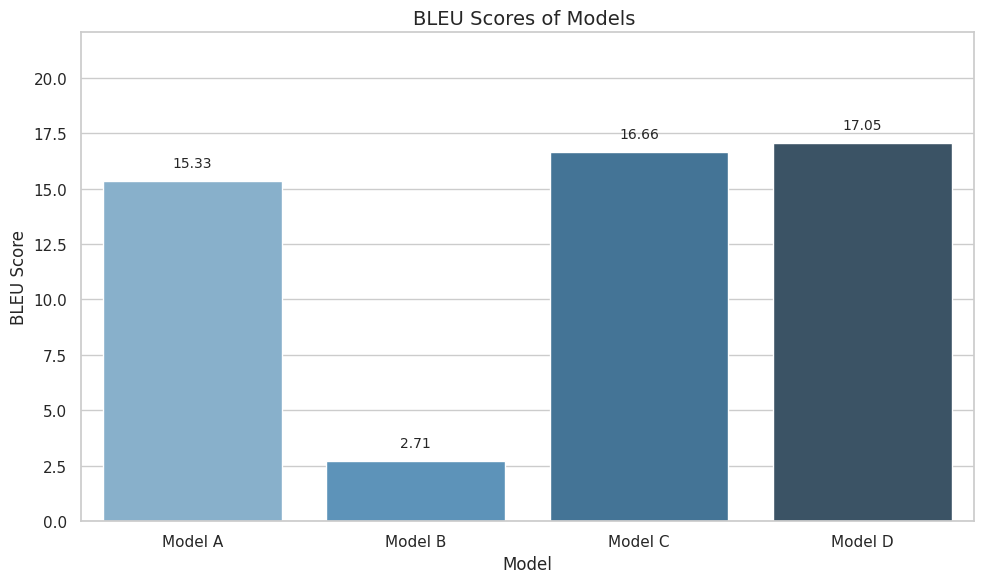

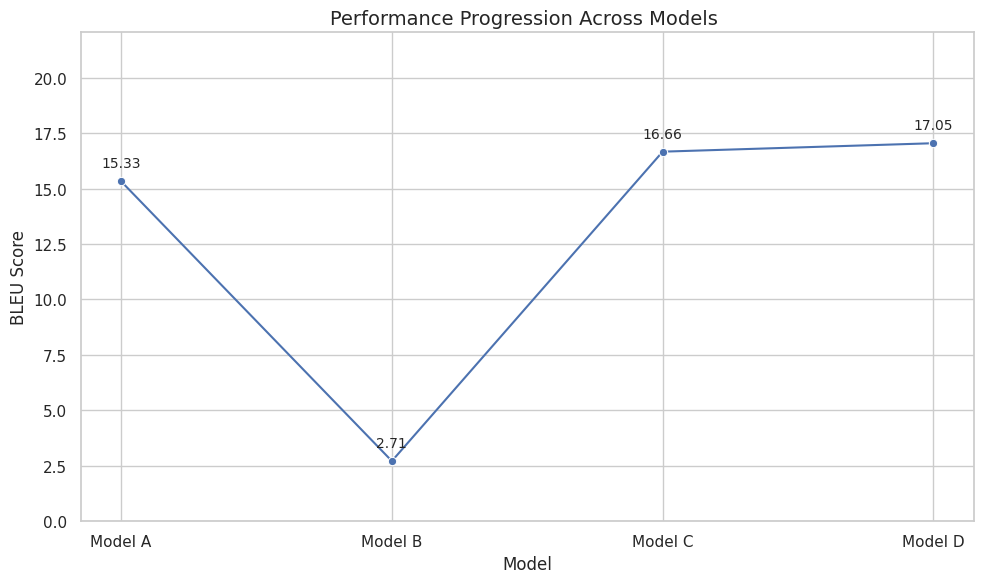

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Define models and BLEU scores
models = ["Model A", "Model B", "Model C", "Model D"]
bleus = [bleu_a, bleu_b, bleu_c, bleu_d]

# Create a DataFrame for better plotting
data = pd.DataFrame({"Model": models, "BLEU Score": bleus})
print("BLEU Scores DataFrame:")
print(data)

# Set style for better aesthetics
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="Model", y="BLEU Score", hue="Model", data=data, palette="Blues_d", legend=False)
plt.title("BLEU Scores of Models ", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("BLEU Score", fontsize=12)

# Add text labels above bars
for i, v in enumerate(bleus):
    plt.text(i, v + 0.5, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set y-axis limit
plt.ylim(0, max(bleus) + 5)  # Increased margin for better visibility
plt.tight_layout()
# plt.show()

# Save the plot
plt.savefig("bleu_scores_bar_plot.png")

# Create line plot (to show progression)
plt.figure(figsize=(10, 6))
line_plot = sns.lineplot(x="Model", y="BLEU Score", data=data, marker="o", color="b")
plt.title("Performance Progression Across Models ", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("BLEU Score", fontsize=12)

# Add text labels above points
for i, v in enumerate(bleus):
    plt.text(i, v + 0.5, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set y-axis limit
plt.ylim(0, max(bleus) + 5)
plt.tight_layout()

# Save the line plot
plt.savefig("bleu_scores_line_plot.png")
# print("Line plot saved as 'bleu_scores_line_plot.png'")

# Show the line plot
plt.show()
